<a href="https://colab.research.google.com/github/adeebiscoding/tenserflow/blob/main/nlp_sentiment_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I make about 6 models using Naive Bayes, Deep Learning, and pre trained models to analyze emotion in sentences from a kaggle dataset. Later, i also evaluate the best model using a confusion matrix to find out where majority of the errors are.

##Downloading Kaggle

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cc81ad62-e410-4b96-7c10-c5f975168baf)


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
files.upload()
#Upload your username and pwd here

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"adeeb120","key":"0291153398d111925e92d503fa2978d6"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

emotions-dataset-for-nlp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip emotions-dataset-for-nlp

Archive:  emotions-dataset-for-nlp.zip
replace test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace val.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
#added title columns to .txt files

##Prepping inputs

In [ ]:
train_df = pd.read_csv(filepath_or_buffer ="/content/train.txt" ,sep=";")
test_df = pd.read_csv(filepath_or_buffer ="/content/test.txt" ,sep=";")
val_df = pd.read_csv(filepath_or_buffer ="/content/val.txt" ,sep=";")

In [ ]:
shuffle_train_df = train_df.sample(frac = 1)
shuffle_val_df = val_df.sample(frac = 1)
shuffle_test_df = test_df.sample(frac = 1)

shuffle_train_df_copy = train_df.sample(frac = 1)
shuffle_val_df_copy = val_df.sample(frac = 1)
shuffle_test_df_copy = test_df.sample(frac = 1)


##One hot encodeing data

In [ ]:
shuffle_train_df_one_hot = pd.get_dummies(shuffle_train_df, columns = ["emotion"])

In [ ]:
shuffle_train_df_one_hot

,review,emotion_anger,emotion_fear,emotion_joy,emotion_love,emotion_sadness,emotion_surprise
5140,i won t argue with those who are disabled abou...,0,0,1,0,0,0
4174,i feel free to create the definition of what i...,0,0,1,0,0,0
4731,i know i said that i would get this to you guy...,0,0,1,0,0,0
14766,im feeling like a tortured teen i decided to p...,0,1,0,0,0,0
1461,i feel confident that we will be blessed with ...,0,0,1,0,0,0
...,...,...,...,...,...,...,...
6010,watched a horror movie which involved sexual a...,0,1,0,0,0,0
815,i am limiting myself to what i can reasonably ...,0,0,0,0,1,0
1731,i grappled with was guilt that relatives and f...,1,0,0,0,0,0
9020,i dont think i misinterpreted at all helped me...,0,0,1,0,0,0


In [ ]:
shuffle_test_df.columns

Index(['review', 'emotion'], dtype='object')

In [ ]:
shuffle_test_df_one_hot = pd.get_dummies(shuffle_test_df, columns = ["emotion"])
shuffle_val_df_one_hot = pd.get_dummies(shuffle_val_df, columns = ["emotion"])

##Visualizing random samples of data

In [ ]:
def visualize(df, count):
  rand_idx = random.sample(range(0,len(df)), count)
  for x in range (count):
    print(f'''
      review: {df.loc[rand_idx[x]]["review"]}

      emotion: {df.loc[rand_idx[x]]["emotion"]}

      ------------------------------------------
    ''')

In [ ]:
visualize(shuffle_train_df, 3)


      review: i do i feel like i just make him mad or upset and he doesn t talk to me

      emotion: anger

      ------------------------------------------
    

      review: i feel fairly sure readers will continue to pay for fiction

      emotion: joy

      ------------------------------------------
    

      review: i did not feel like i was on the edge and it got to a point where i wasn t bothered about who wins and to hell with it whether this fight will even end

      emotion: anger

      ------------------------------------------
    


In [ ]:
visualize(shuffle_val_df, 3)


      review: i feel that with my superior vegan diet i should not get sick at all

      emotion: joy

      ------------------------------------------
    

      review: i always feel scared when i see a cop instead of feeling safe

      emotion: fear

      ------------------------------------------
    

      review: i dunno i just feel so useless

      emotion: sadness

      ------------------------------------------
    


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

###Seeing if data set is balanced

In [ ]:
for vals in train_df["emotion"].unique():
  print(f'''
  {vals} : {len(train_df[train_df["emotion"]==vals])} 
  ''')


  sadness : 4666 
  

  anger : 2159 
  

  love : 1304 
  

  surprise : 572 
  

  fear : 1937 
  

  joy : 5362 
  


Our data is unfortunatly imbalanced

##Using Scikit learn for our model

We will use Naive Bayes algos and see how it performs 

###CategoricalNB

This uses tfidfvectorizer to input numerical data into multinomialNB layer.

In [ ]:
shuffle_train_df_one_hot.columns

Index(['review', 'emotion_anger', 'emotion_fear', 'emotion_joy',
       'emotion_love', 'emotion_sadness', 'emotion_surprise'],
      dtype='object')

In [ ]:
shuffle_train_df_one_hot[shuffle_train_df_one_hot.columns[1:]]

,emotion_anger,emotion_fear,emotion_joy,emotion_love,emotion_sadness,emotion_surprise
5140,0,0,1,0,0,0
4174,0,0,1,0,0,0
4731,0,0,1,0,0,0
14766,0,1,0,0,0,0
1461,0,0,1,0,0,0
...,...,...,...,...,...,...
6010,0,1,0,0,0,0
815,0,0,0,0,1,0
1731,1,0,0,0,0,0
9020,0,0,1,0,0,0


CategoricalNB requires dense input so we will convert to dense

In [ ]:
# from sklearn.model_selection import train_test_split

# train_sentences, val_sentences, train_labels, val_labels = train_test_split(shuffle_train_df["review"].to_numpy(),
#                                                                             shuffle_train_df["emotion"].to_numpy(),
#                                                                             test_size=0.01, # dedicate 10% of samples to validation set
#                                                                             random_state=42,
#                                                                             #stratify=shuffle_train_df["emotion"].to_numpy()
#                                                                             )

In [ ]:
# converting code to originalEncoder since it CategoricalNB works with OriginalEncoder
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit( shuffle_train_df[["emotion"]])
shuffle_train_df[["emotion"]] = enc.transform(shuffle_train_df[["emotion"]])

In [ ]:
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, CategoricalNB 
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline - > works in order like sequential in tensorflow
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("to_dense", DenseTransformer()),
                    ("clf", CategoricalNB()) # model the text, clf = classifier
])

# Fit the pipeline to the training data
#model_0.fit(shuffle_train_df["review"].to_numpy(dtype = "str"), shuffle_train_df["emotion"].to_numpy())
#model_0.fit(train_sentences, train_labels)
train_X = shuffle_train_df["review"].to_numpy()
train_y = shuffle_train_df[["emotion"]].to_numpy()
model_0.fit(shuffle_train_df["review"].to_numpy(), shuffle_train_df[["emotion"]].to_numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('to_dense',
                 <__main__.DenseTransformer object at 0x7fef9794e590>),
                ('clf', CategoricalNB())])

In [ ]:
#Evaluating model_0

enc.fit( shuffle_val_df[["emotion"]])
shuffle_val_df[["emotion"]] = enc.transform(shuffle_val_df[["emotion"]])

val_X = shuffle_val_df["review"].to_numpy()
val_y = shuffle_val_df[["emotion"]].to_numpy()

model_0_score = model_0.score(val_X,val_y)
model_0_score

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


0.352

In [ ]:
print(f"Total unique categories {len(shuffle_test_df.emotion.unique())}")

Total unique categories 6


Our model is at 35.2% accuracy. Which means its doing slightly better than guesing since guessing would mean it should perform at 17% accuracy (100/6 = 16.6)

##Setting up mixed precision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

##RNNs

###Creating vectorizer

Used for feeding into embedding layer which finds patterns and requires int as inputs

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
#setup text vectorization variables
text_vectorizer = TextVectorization(max_tokens=16000, # take top 16k words for analysis
                                    output_mode = "int",
                                    output_sequence_length = 20 #length of output vector
                                    )

In [ ]:
# fit text vectorizer to training text
text_vectorizer.adapt(train_X)

In [ ]:
#chose random sentence from training data and tokenize it
random_sentence = random.choice(train_X)
print(f"original:\n {random_sentence}\
      \n\n\nVecotrized version\n {text_vectorizer([random_sentence])}")

original:
 i feel when you are a caring person you attract other caring people into your life      


Vecotrized version
 [[   2    3   34   31   44    7  437  171   31 7277  120  437   63  106
   110   78    0    0    0    0]]


In [ ]:
#get unique words in vocab
words_in_vocab = text_vectorizer.get_vocabulary() #will be `max_tokens` or lesser
top_5 = words_in_vocab[:5]
bottom_5 = words_in_vocab[-5:]

print(f'''
  words_in_vocab: {len(words_in_vocab)}
  top5: {top_5} 
  bottom5: {bottom_5}''')

#[UNK] is unknown, there might be lot of unknown words


  words_in_vocab: 15214
  top5: ['', '[UNK]', 'i', 'feel', 'and'] 
  bottom5: ['aahhh', 'aac', 'aaaand', 'aaaaand', 'aaaaaaand']


###Creating embedding

**Requires +ve int input**

* `input_dim` = size of voacb

* `output_dim` = size of embedding vector, if 3, then each token represented with 3 values

* `input_length` = length of sequences being passewd to the embedding layer

In [ ]:
from tensorflow.keras import layers, Model
embedding  = layers.Embedding(input_dim = 16000,
                              output_dim = 256,# output shape, better to be multiple of 8
                              input_length = 20)

###using LTSM

Long short term memory

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(128)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(6, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM")

(None, 20, 256)
(None, 128)


In [ ]:
model_1.summary()

Model: "model_1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 20, 256)           4096000   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4,293,894
Trainable params: 4,293,894
Non-trainable params: 0
____________________________________________

In [ ]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
val_y_onehot = pd.get_dummies(shuffle_val_df_copy.emotion, prefix = "emotion")
train_y_onehot = pd.get_dummies(shuffle_train_df_copy.emotion, prefix = "emotion")

In [ ]:
shuffle_val_df_copy.emotion

554        anger
776      sadness
1299     sadness
1282    surprise
539          joy
          ...   
1267     sadness
1655        fear
1409        fear
808         love
392      sadness
Name: emotion, Length: 2000, dtype: object

In [ ]:
train_X_copy = shuffle_train_df_copy["review"].to_numpy()
val_X_copy = shuffle_val_df_copy["review"].to_numpy()

In [ ]:
m1 = model_1.fit(train_X_copy, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_y_onehot,
                              epochs=5,
                              validation_data=(val_X_copy, val_y_onehot),
                              #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
            )

Epoch 1/5
500/500 [==============================] - 10s 9ms/step - loss: 1.0698 - accuracy: 0.5810 - val_loss: 0.5558 - val_accuracy: 0.8075
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 0.3539 - accuracy: 0.8788 - val_loss: 0.3902 - val_accuracy: 0.8525
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 0.2117 - accuracy: 0.9251 - val_loss: 0.4516 - val_accuracy: 0.8520
Epoch 4/5
500/500 [==============================] - 4s 8ms/step - loss: 0.1379 - accuracy: 0.9502 - val_loss: 0.4884 - val_accuracy: 0.8555
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0946 - accuracy: 0.9657 - val_loss: 0.5910 - val_accuracy: 0.8425


####Evalauting model 1

In [ ]:
class_names = shuffle_val_df_copy.emotion.unique()
class_names = np.sort(class_names)

In [ ]:
model_1_pred_probs = model_1.predict(shuffle_test_df_copy.review.to_numpy())
model_1_pred_probs.shape
model_1_pred = tf.round(model_1_pred_probs)
model_1_pred

63/63 [==============================] - 1s 3ms/step


<tf.Tensor: shape=(2000, 6), dtype=float16, numpy=
array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float16)>

In [ ]:
model_1_actual  = pd.get_dummies(shuffle_test_df_copy.emotion.to_numpy())
model_1_analysis = calculate_results(model_1_actual, model_1_pred)

In [ ]:
model_1_analysis

{'accuracy': 82.3,
 'precision': 0.8547665689914529,
 'recall': 0.823,
 'f1': 0.8371856301923574}

###model 2

(does not work without one hot encoding) :(

no one hot encoding

In [ ]:
model_2 = tf.keras.models.clone_model(model_1)

In [ ]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# model_2.fit(train_X, # input sentences can be a list of strings due to text preprocessing layer built-in model
#                               train_y,
#                               epochs=5,
#                               validation_data=(val_X, val_y),
#                               #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
#             )

###model 3

using LTSM and GRU

In [ ]:
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(6, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
m3 = model_3.fit(train_X_copy, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_y_onehot,
                              epochs=5,
                              validation_data=(val_X_copy, val_y_onehot),
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
            )

Epoch 1/5
500/500 [==============================] - 9s 11ms/step - loss: 0.4226 - accuracy: 0.8399 - val_loss: 0.5859 - val_accuracy: 0.8490
Epoch 2/5
500/500 [==============================] - 4s 9ms/step - loss: 0.0976 - accuracy: 0.9665 - val_loss: 0.5881 - val_accuracy: 0.8475
Epoch 3/5
500/500 [==============================] - 5s 9ms/step - loss: 0.0614 - accuracy: 0.9783 - val_loss: 0.6504 - val_accuracy: 0.8435
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0458 - accuracy: 0.9831 - val_loss: 0.7608 - val_accuracy: 0.8345
Epoch 5/5
500/500 [==============================] - 5s 9ms/step - loss: 0.0338 - accuracy: 0.9872 - val_loss: 0.8241 - val_accuracy: 0.8330


In [ ]:
model_3_pred_probs = model_3.predict(shuffle_test_df_copy.review.to_numpy())
model_3_pred = tf.round(model_3_pred_probs)

63/63 [==============================] - 1s 3ms/step


In [ ]:
model_3_analysis = calculate_results(model_1_actual, model_3_pred)
model_3_analysis["precision"]> model_1_analysis["precision"]

False

In [ ]:
model_3_analysis

{'accuracy': 81.69999999999999,
 'precision': 0.832305779934104,
 'recall': 0.817,
 'f1': 0.8238247758397597}

the GRU layers pulled the accuracy and precison down :(

###model 4

Using GRU and bidirectional

In [ ]:
# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(6, activation="softmax")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
m4 = model_4.fit(train_X_copy, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_y_onehot,
                              epochs=5,
                              validation_data=(val_X_copy, val_y_onehot),
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
            )

Epoch 1/5
500/500 [==============================] - 9s 12ms/step - loss: 0.2756 - accuracy: 0.9066 - val_loss: 0.6608 - val_accuracy: 0.8335
Epoch 2/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0635 - accuracy: 0.9793 - val_loss: 0.7060 - val_accuracy: 0.8255
Epoch 3/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0411 - accuracy: 0.9866 - val_loss: 0.8058 - val_accuracy: 0.8320
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.8545 - val_accuracy: 0.8195
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0308 - accuracy: 0.9886 - val_loss: 0.8838 - val_accuracy: 0.8180


In [ ]:
#see if mixed precison works
for layer in model_4.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 True string <Policy "string">
text_vectorization True string <Policy "string">
embedding True float32 <Policy "mixed_float16">
bidirectional True float32 <Policy "mixed_float16">
dense_5 True float32 <Policy "mixed_float16">


In [ ]:
model_4_pred_probs = model_4.predict(shuffle_test_df_copy.review.to_numpy())
model_4_pred = tf.round(model_4_pred_probs)
model_4_analysis = calculate_results(model_1_actual, model_4_pred)
model_4_analysis

63/63 [==============================] - 1s 3ms/step


{'accuracy': 80.05,
 'precision': 0.8190063349171878,
 'recall': 0.8005,
 'f1': 0.8078929437261764}

##model 5

using conv1d

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(6, activation="softmax")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
m5 = model_5.fit(train_X_copy, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_y_onehot,
                              epochs=5,
                              validation_data=(val_X_copy, val_y_onehot),
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
            )

Epoch 1/5
500/500 [==============================] - 9s 7ms/step - loss: 0.1899 - accuracy: 0.9439 - val_loss: 0.5645 - val_accuracy: 0.8410
Epoch 2/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0537 - accuracy: 0.9836 - val_loss: 0.6693 - val_accuracy: 0.8355
Epoch 3/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0260 - accuracy: 0.9925 - val_loss: 0.7652 - val_accuracy: 0.8245
Epoch 4/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.8305 - val_accuracy: 0.8310
Epoch 5/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0148 - accuracy: 0.9962 - val_loss: 0.8886 - val_accuracy: 0.8325


This layer was the fastest with really good accuracy

In [ ]:
model_5_pred_probs = model_5.predict(shuffle_test_df_copy.review.to_numpy())
model_5_pred = tf.round(model_5_pred_probs)
model_5_analysis = calculate_results(model_1_actual, model_5_pred)
model_5_analysis

63/63 [==============================] - 0s 2ms/step


{'accuracy': 82.0,
 'precision': 0.8321237394649457,
 'recall': 0.82,
 'f1': 0.8258005920553889}

##Evaluating models using loss curves

In [ ]:
def plot_loss_curves(history, title):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title(f'{title}- Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title(f'{title}- Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

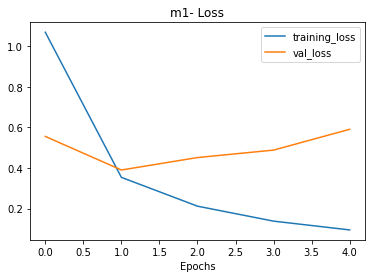

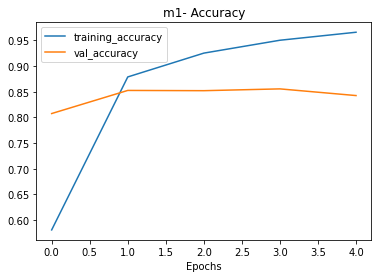

In [ ]:
plot_loss_curves(m1,"m1")

This tells me model 1 might be **slightly** overfitting since val loss was increasing but training loss was dereasing

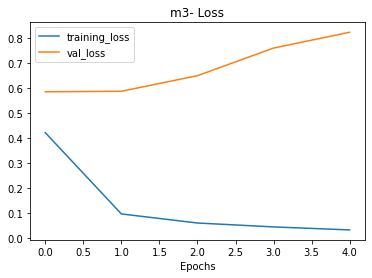

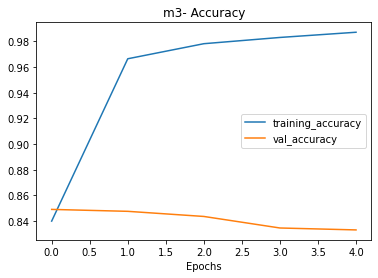

In [ ]:
plot_loss_curves(m3,"m3")

model_3 was good!!

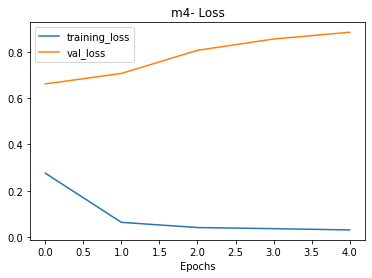

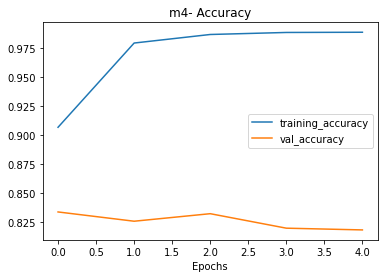

In [ ]:
plot_loss_curves(m4,"m4")

model_4 was also slightly overfitting for same reasons as model_1

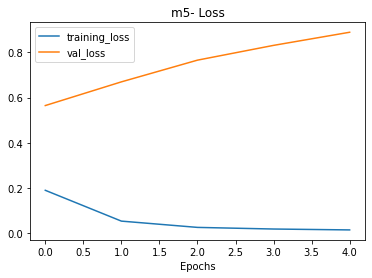

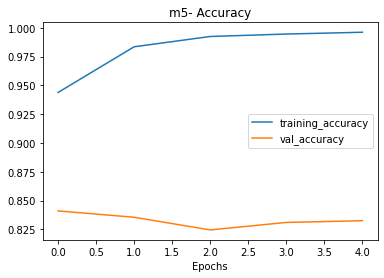

In [ ]:
plot_loss_curves(m5,"m5")

model_5 was okayish in terms of evaluation but was fastest in execution 

##model 6: 

using feature extraction by pre trained model

We will be using BERT

In [ ]:
!pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub

In [ ]:
# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# preprocessor = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# encoder_inputs = preprocessor(text_input)
# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4",
#     trainable=True)
# outputs = encoder(encoder_inputs)
# #x = layers.GlobalMaxPool1D()(outputs)
# #outputs = layers.Dense(6, activation="softmax")(x)
# pooled_output = outputs["pooled_output"]      # [batch_size, 1024].
# sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 1024].

In [ ]:
# embedding_model = tf.keras.Model(text_input, pooled_output)

In [ ]:
# embedding_model.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

In [ ]:
# m6 = embedding_model.fit(train_X_copy, # input sentences can be a list of strings due to text preprocessing layer built-in model
#                               train_y_onehot,
#                               epochs=5,
#                               validation_data=(val_X_copy, val_y_onehot),
#                               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
#             )

In [ ]:
# #preprocess
# preprocessor = hub.load(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# # Step 1: tokenize batches of text inputs.
# text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string),
#                ...] # This SavedModel accepts up to 2 text inputs.
# tokenize = hub.KerasLayer(preprocessor.tokenize)
# tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# # Step 3: pack input sequences for the Transformer encoder.
# seq_length = 128  # Your choice here.
# bert_pack_inputs = hub.KerasLayer(
#     preprocessor.bert_pack_inputs,
#     arguments=dict(seq_length=seq_length, batch_size = 6))  # Optional argument.
# encoder_inputs = bert_pack_inputs(tokenized_inputs)

In [ ]:
# #model
# # text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# # preprocessor = hub.KerasLayer(
# #     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# # encoder_inputs = preprocessor(text_input)
# # encoder = hub.KerasLayer(
# #     "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4",
# #     trainable=True)
# outputs = encoder(encoder_inputs)
# pooled_output = outputs["pooled_output"]
# sequence_output = outputs["sequence_output"]

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(6, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model_6 = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model_6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
m6 = model_6.fit(train_X_copy, train_y_onehot, epochs=3)

Epoch 1/3
500/500 [==============================] - 169s 319ms/step - loss: 1.5556 - accuracy: 0.3886
Epoch 2/3
500/500 [==============================] - 165s 330ms/step - loss: 1.4696 - accuracy: 0.4366
Epoch 3/3
500/500 [==============================] - 165s 330ms/step - loss: 1.4326 - accuracy: 0.4567


In [ ]:
model_6.evaluate(val_X_copy, val_y_onehot)

63/63 [==============================] - 21s 328ms/step - loss: 1.4145 - accuracy: 0.4865


[1.4144999980926514, 0.48649999499320984]

##Model 7

using USE model

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 
model_7 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(128, activation="relu"),  
  layers.Dense(64, activation="relu"),
  #layers.Dense(128, activation="relu"),  
  layers.Dense(6, activation="sigmoid")
], name="model_7_USE")

# Compile model
model_7.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_7 = model_7.fit(train_X_copy,
                              train_y_onehot,
                              epochs=5,
                              validation_data=(val_X_copy, val_y_onehot),
                              callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/5
500/500 [==============================] - 8s 11ms/step - loss: 1.1147 - accuracy: 0.5867 - val_loss: 0.9619 - val_accuracy: 0.6325
Epoch 2/5
500/500 [==============================] - 5s 10ms/step - loss: 0.9223 - accuracy: 0.6557 - val_loss: 0.9268 - val_accuracy: 0.6445
Epoch 3/5
500/500 [==============================] - 6s 11ms/step - loss: 0.8658 - accuracy: 0.6754 - val_loss: 0.9004 - val_accuracy: 0.6620
Epoch 4/5
500/500 [==============================] - 5s 11ms/step - loss: 0.8086 - accuracy: 0.6963 - val_loss: 0.8775 - val_accuracy: 0.6690
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 0.7507 - accuracy: 0.7202 - val_loss: 0.8649 - val_accuracy: 0.6660


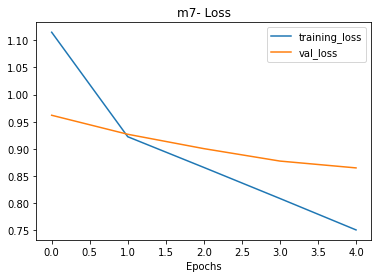

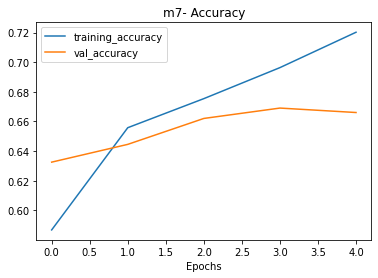

In [ ]:
plot_loss_curves(model_7,"m7")

this model is working pretty well

##Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

We will make this matrix for model 5 since it was really good

In [ ]:
cm = confusion_matrix(model_1_actual.to_numpy().argmax(axis=1), model_5_pred_probs.argmax(axis=1))
cm

array([[220,   8,  17,   6,  23,   1],
       [ 10, 177,   3,   6,  17,  11],
       [ 13,   7, 601,  40,  32,   2],
       [  6,   3,  39, 103,   7,   1],
       [ 14,   9,  47,   9, 499,   3],
       [  1,   9,   5,   0,   4,  47]])

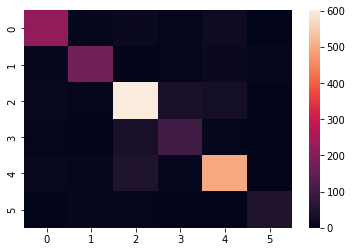

In [ ]:
sns.heatmap(cm)

We can see the model confuses `4` and `2`, `3` and `2` a lot so we can work on the dataset to fix that

In [ ]:
class_names[2:5] # things the model is confusing

array(['joy', 'love', 'sadness'], dtype=object)